## TL;DR

This takes the ideas from my previous kernel:

- Blending with Linear Regression: https://www.kaggle.com/suicaokhoailang/blending-with-linear-regression-0-688-lb

- Beating the baseline with ONE WEIRD TRICK!: https://www.kaggle.com/suicaokhoailang/beating-the-baseline-with-one-weird-trick-0-691

The trick is a bit weirder this time, here's how to reproduce:

- Training an ensemble with normal train/validation split on a different kernel or locally.

- Blend the ensemble with linear regression, take the coefficients and the optimal threshold.

- Train and commit on full dataset, no validation, use the precomputed values above.

The model is surprisingly robust, scoring 0.692 in two consecutive runs.

Again, thank **Shujian Liu** for his great contributions.

## V6
 Improve your Score with some Text Preprocessing
 省略形、missspeliingを直したら下がっちゃった
 0.690
 
 ## V7
 とりまadd_lowerだけのでやってみる

* https://www.kaggle.com/shujian/single-rnn-with-4-folds-clr by shujian
* https://www.kaggle.com/sudalairajkumar/a-look-at-different-embeddings by SRK
* https://www.kaggle.com/christofhenkel/how-to-preprocessing-when-using-embeddings by Dieter
* https://www.kaggle.com/shujian/mix-of-nn-models-based-on-meta-embedding by shujian
* https://www.kaggle.com/gmhost/gru-capsule by Puck Wang
* Based on SRK's kernel: https://www.kaggle.com/sudalairajkumar/a-look-at-different-embeddings
* Vladimir Demidov's 2DCNN textClassifier: https://www.kaggle.com/yekenot/2dcnn-textclassifier
* Attention layer from Khoi Ngyuen: https://www.kaggle.com/suicaokhoailang/lstm-attention-baseline-0-652-lb
* LSTM model from Strideradu: https://www.kaggle.com/strideradu/word2vec-and-gensim-go-go-go
* https://www.kaggle.com/danofer/different-embeddings-with-attention-fork

In [1]:
import tensorflow as tf
sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))

In [2]:
with tf.device('/gpu:0'):
    a = tf.constant([1.0, 2.0, 3.0, 4.0, 5.0, 6.0], shape=[2, 3], name='a')
    b = tf.constant([1.0, 2.0, 3.0, 4.0, 5.0, 6.0], shape=[3, 2], name='b')
    c = tf.matmul(a, b)

with tf.Session() as sess:
    print (sess.run(c))

[[22. 28.]
 [49. 64.]]


In [45]:
%%time
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

import time

import codecs

import matplotlib.pyplot as plt
# Any results you write to the current directory are saved as output.

['train.csv', 'embeddings', 'test.csv']
CPU times: user 161 ms, sys: 20.2 ms, total: 181 ms
Wall time: 554 ms


In [4]:
%%time
## some config values 
embed_size = 300 # how big is each word vector
max_features = 95000 # how many unique words to use (i.e num rows in embedding vector)
maxlen = 70 # max number of words in a question to use

CPU times: user 6 µs, sys: 0 ns, total: 6 µs
Wall time: 9.06 µs


**Load packages and data**

In [5]:
import os
import time
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from tqdm import tqdm
import math
from sklearn.model_selection import train_test_split
from sklearn import metrics

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, CuDNNLSTM, Embedding, Dropout, Activation, CuDNNGRU, Conv1D
from keras.layers import Bidirectional, GlobalMaxPool1D, GlobalMaxPooling1D, GlobalAveragePooling1D
from keras.layers import Input, Embedding, Dense, Conv2D, MaxPool2D, concatenate, Conv1D, MaxPool1D
from keras.layers import Reshape, Flatten, Concatenate, Dropout, SpatialDropout1D
from keras.optimizers import Adam
from keras.models import Model
from keras import backend as K
from keras.engine.topology import Layer
from keras import initializers, regularizers, constraints, optimizers, layers

Using TensorFlow backend.


In [6]:
from keras import backend as K
K.tensorflow_backend._get_available_gpus()

['/job:localhost/replica:0/task:0/device:GPU:0']

In [7]:
## some config values 
embed_size = 300 # how big is each word vector
max_features = 95000 # how many unique words to use (i.e num rows in embedding vector)
maxlen = 70 # max number of words in a question to use

In [8]:
# puncts = [ '"', ')', '(', '-', '|', "'", '$', '&', '/', '[', ']', '>', '%', '=', '#', '*', '+', '\\', '•',  '~', '@', '£', 
#  '·', '_', '{', '}', '©', '^', '®', '`',  '<', '→', '°', '€', '™', '›',  '♥', '←', '×', '§', '″', '′', 'Â', '█', '½', 'à', '…', 
#  '“', '★', '”', '–', '●', 'â', '►', '−', '¢', '²', '¬', '░', '¶', '↑', '±', '¿', '▾', '═', '¦', '║', '―', '¥', '▓', '—', '‹', '─', 
#  '▒', '：', '¼', '⊕', '▼', '▪', '†', '■', '’', '▀', '¨', '▄', '♫', '☆', 'é', '¯', '♦', '¤', '▲', 'è', '¸', '¾', 'Ã', '⋅', '‘', '∞', 
#  '∙', '）', '↓', '、', '│', '（', '»', '，', '♪', '╩', '╚', '³', '・', '╦', '╣', '╔', '╗', '▬', '❤', 'ï', 'Ø', '¹', '≤', '‡', '√', 
# 'é', '&amp;','₹', 'á', '²', 'ế', '청', '하', '¨', '‘', '√', '\xa0', '高', '端', '大', '气', '上', '档', '次', '_', '½', 'π', '#', 
# '小', '鹿', '乱', '撞', '成', '语', 'ë', 'à', 'ç', '@', 'ü', 'č', 'ć', 'ž', 'đ', '°', 'द', 'े', 'श', '्', 'र', 'ो', 'ह', 
# 'ि', 'प', 'स', 'थ', 'त', 'न', 'व', 'ा', 'ल', 'ं', '林', '彪', '€', '\u200b', '˚', 'ö', '~', '—', '越', '人', 'च', 'म', 'क', 
# 'ु', 'य', 'ी', 'ê', 'ă', 'ễ', '∞', '抗', '日', '神', '剧', '，', '\uf02d', '–', 'ご', 'め', 'な', 'さ', 'い', 'す', 
# 'み', 'ま', 'せ', 'ん', 'ó', 'è', '£', '¡', 'ś', '≤', '¿', 'λ', '魔', '法', '师', '）', 'ğ', 'ñ', 'ř', '그', '자', '식', '멀', 
# '쩡', '다', '인', '공', '호', '흡', '데', '혀', '밀', '어', '넣', '는', '거', '보', '니', 'ǒ', 'ú', '️', 'ش', 'ه', 'ا', 'د',
# 'ة', 'ل', 'ت', 'َ', 'ع', 'م', 'ّ', 'ق', 'ِ', 'ف', 'ي', 'ب', 'ح', 'ْ', 'ث', '³', '饭', '可', '以', '吃', '话', '不', '讲', 
# '∈', 'ℝ', '爾', '汝', '文', '言', '∀', '禮', 'इ', 'ब', 'छ', 'ड', '़', 'ʒ', '有', '「', '寧', '錯', '殺', '一', '千', '絕', 
# '放', '過', '」', '之', '勢', '㏒', '㏑', 'ू', 'â', 'ω', 'ą', 'ō', '精', '杯', 'í', '生', '懸', '命', 'ਨ', 'ਾ', 'ਮ', 'ੁ', 
# '₁', '₂', 'ϵ', 'ä', 'к', 'ɾ', '\ufeff', 'ã', '©', '\x9d', 'ū', '™', '＝', 'ù', 'ɪ', 'ŋ', 'خ', 'ر', 'س', 'ن', 'ḵ', 'ā']
puncts = [',', '.', '"', ':', ')', '(', '-', '!', '?', '|', ';', "'", '$', '&', '/', '[', ']', '>', '%', '=', '#', '*', '+', '\\', '•',  '~', '@', '£', 
 '·', '_', '{', '}', '©', '^', '®', '`',  '<', '→', '°', '€', '™', '›',  '♥', '←', '×', '§', '″', '′', 'Â', '█', '½', 'à', '…', 
 '“', '★', '”', '–', '●', 'â', '►', '−', '¢', '²', '¬', '░', '¶', '↑', '±', '¿', '▾', '═', '¦', '║', '―', '¥', '▓', '—', '‹', '─', 
 '▒', '：', '¼', '⊕', '▼', '▪', '†', '■', '’', '▀', '¨', '▄', '♫', '☆', 'é', '¯', '♦', '¤', '▲', 'è', '¸', '¾', 'Ã', '⋅', '‘', '∞', 
 '∙', '）', '↓', '、', '│', '（', '»', '，', '♪', '╩', '╚', '³', '・', '╦', '╣', '╔', '╗', '▬', '❤', 'ï', 'Ø', '¹', '≤', '‡', '√', ]
def clean_text(x):
    x = str(x)
    for punct in puncts:
        x = x.replace(punct, ' {punct} '.format(punct=punct))
    return x

def split_text(x):
    x = wordninja.split(x)
    return '-'.join(x)

In [9]:
contraction_mapping = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not", "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not", "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",  "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would", "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would", "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam", "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have", "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock", "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have", "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is", "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as", "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would", "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have", "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have", "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are", "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",  "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is", "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have", "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have", "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all", "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have","you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have", "you're": "you are", "you've": "you have" }

def clean_contractions(text, mapping):
    """
    Parameters
    -----
        text: string
            質問
        mapping: dict
            省略形：元の単語たち
    Returns
    -----
        text: string
            省略形が直されたテキスト
    """
    # 点を統一する
    specials = ["’", "‘", "´", "`"]
    for s in specials:
        text = text.replace(s, "'")
        
    # 省略形に入ってるのは、省略されてない単語に、そうでなければそのまま
    text = ' '.join([mapping[t] if t in mapping else t for t in text.split(" ")])
    return text

punct_mapping = {"‘": "'", "₹": "e", "´": "'", "°": "", "€": "e", "™": "tm", "√": " sqrt ", "×": "x", "²": "2", "—": "-", "–": "-", "’": "'", "_": "-", "`": "'", '“': '"', '”': '"', '“': '"', "£": "e", '∞': 'infinity', 'θ': 'theta', '÷': '/', 'α': 'alpha', '•': '.', 'à': 'a', '−': '-', 'β': 'beta', '∅': '', '³': '3', 'π': 'pi', '§': "", '©':"copyright", '®':"", '±':'plusminus', '·':" ", '»':" ", '½': 'half', '¾': "three-fourth", 'é':"e", 'ï':"i", '…':'...', '→':'->', '≤':'less'}
def clean_special_chars(text, punct, mapping):
    
    # knownに入れ替える
    for p in mapping:
        text = text.replace(p, mapping[p])
        
    # punctsの周りをわかちする
    for p in punct:
        text = text.replace(p, ' {p} '.format(p=p))
    
    # 入れ替えるのと分かちも一緒にしてる
    specials = {'\u200b': ' ', '…': ' ... ', '\ufeff': '', 'करना': '', 'है': ''}  # Other special characters that I have to deal with in last
    for s in specials:
        text = text.replace(s, specials[s])
    
    return text

mispell_dict = {'colour': 'color', 'centre': 'center', 'favourite': 'favorite', 'travelling': 'traveling', 'counselling': 'counseling', 'theatre': 'theater', 'cancelled': 'canceled', 'labour': 'labor', 'organisation': 'organization', 'wwii': 'world war 2', 'citicise': 'criticize', 'youtu ': 'youtube ', 'Qoura': 'Quora', 'sallary': 'salary', 'Whta': 'What', 'narcisist': 'narcissist', 'howdo': 'how do', 'whatare': 'what are', 'howcan': 'how can', 'howmuch': 'how much', 'howmany': 'how many', 'whydo': 'why do', 'doI': 'do I', 'theBest': 'the best', 'howdoes': 'how does', 'mastrubation': 'masturbation', 'mastrubate': 'masturbate', "mastrubating": 'masturbating', 'pennis': 'penis', 'Etherium': 'Ethereum', 'narcissit': 'narcissist', 'bigdata': 'big data', '2k17': '2017', '2k18': '2018', 'qouta': 'quota', 'exboyfriend': 'ex boyfriend', 'airhostess': 'air hostess', "whst": 'what', 'watsapp': 'whatsapp', 'demonitisation': 'demonetization', 'demonitization': 'demonetization', 'demonetisation': 'demonetization'}
def correct_spelling(x, dic):
    for word in dic.keys():
        x = x.replace(word, dic[word])
    return x

def build_vocab(texts):
    """
    
    Parameters
    -----
    texts: pandas.Series
        question textの列
        
    Returns
    -----
    dict: 
        単語とカウント
    
    """
    sentences = texts.apply(lambda x: x.split()).values
    vocab = {}
    for sentence in sentences:
        for word in sentence:
            try:
                vocab[word] += 1
            except KeyError:
                vocab[word] = 1
    return vocab


In [10]:
def load_and_prec():
    train_df = pd.read_csv("../input/train.csv")
    test_df = pd.read_csv("../input/test.csv")
    train_df["question_text"] = train_df["question_text"].str.lower()
    test_df["question_text"] = test_df["question_text"].str.lower()
    
    #train_df['question_text'] = train_df['question_text'].apply(lambda x: clean_contractions(x, contraction_mapping))
    #test_df['question_text'] = test_df['question_text'].apply(lambda x: clean_contractions(x, contraction_mapping))
    
    #train_df['question_text'] = train_df['question_text'].apply(lambda x: clean_special_chars(x, puncts, punct_mapping))
    #test_df['question_text'] = test_df['question_text'].apply(lambda x: clean_special_chars(x, puncts, punct_mapping))
    
    #train_df['question_text'] = train_df['question_text'].apply(lambda x: correct_spelling(x, mispell_dict))
    #test_df['question_text'] = test_df['question_text'].apply(lambda x: correct_spelling(x, mispell_dict))
    
    train_df["question_text"] = train_df["question_text"].apply(lambda x: clean_text(x))
    test_df["question_text"] = test_df["question_text"].apply(lambda x: clean_text(x))
    
    print("Train shape : ",train_df.shape)
    print("Test shape : ",test_df.shape)
    
    ## split to train and val
    train_df, val_df = train_test_split(train_df, test_size=0.2, random_state=2018) # hahaha


    ## fill up the missing values
    train_X = train_df["question_text"].fillna("_##_").values
    val_X = val_df["question_text"].fillna("_##_").values
    test_X = test_df["question_text"].fillna("_##_").values

    ## Tokenize the sentences
    tokenizer = Tokenizer(num_words=max_features)
    tokenizer.fit_on_texts(list(train_X))
    train_X = tokenizer.texts_to_sequences(train_X)
    val_X = tokenizer.texts_to_sequences(val_X)
    test_X = tokenizer.texts_to_sequences(test_X)

    ## Pad the sentences 
    train_X = pad_sequences(train_X, maxlen=maxlen)
    val_X = pad_sequences(val_X, maxlen=maxlen)
    test_X = pad_sequences(test_X, maxlen=maxlen)

    ## Get the target values
    train_y = train_df['target'].values
    val_y = val_df['target'].values  
    
    #shuffling the data
    np.random.seed(2018)
    trn_idx = np.random.permutation(len(train_X))
    val_idx = np.random.permutation(len(val_X))

    train_X = train_X[trn_idx]
    val_X = val_X[val_idx]
    train_y = train_y[trn_idx]
    val_y = val_y[val_idx]    
    
    return train_X, val_X, test_X, train_y, val_y, tokenizer.word_index

**Load embeddings**

In [23]:

    
def load_glove(word_index):
    EMBEDDING_FILE = '../input/embeddings/glove.840B.300d/glove.840B.300d.txt'
    def get_coefs(word,*arr): return word, np.asarray(arr, dtype='float32')
    embeddings_index = dict(get_coefs(*o.split(" ")) for o in open(EMBEDDING_FILE))


    all_embs = np.stack(embeddings_index.values())
    emb_mean,emb_std = -0.005838499,0.48782197
    embed_size = all_embs.shape[1]

    # word_index = tokenizer.word_index
    nb_words = min(max_features, len(word_index))
    embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words, embed_size))
    for word, i in word_index.items():
        if i >= max_features: continue
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None: embedding_matrix[i] = embedding_vector
            
    return embedding_matrix 
    
def load_fasttext(word_index):    
    EMBEDDING_FILE = '../input/embeddings/wiki-news-300d-1M/wiki-news-300d-1M.vec'
    def get_coefs(word,*arr): return word, np.asarray(arr, dtype='float32')
    embeddings_index = dict(get_coefs(*o.split(" ")) for o in open(EMBEDDING_FILE) if len(o)>100)

    

    all_embs = np.stack(embeddings_index.values())
    emb_mean,emb_std = all_embs.mean(), all_embs.std()
    embed_size = all_embs.shape[1]

    # word_index = tokenizer.word_index
    nb_words = min(max_features, len(word_index))
    embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words, embed_size))
    for word, i in word_index.items():
        if i >= max_features: continue
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None: embedding_matrix[i] = embedding_vector

    return embedding_matrix

def load_para(word_index):
    EMBEDDING_FILE = '../input/embeddings/paragram_300_sl999/paragram_300_sl999.txt'
    def get_coefs(word,*arr): return word, np.asarray(arr, dtype='float32')
    embeddings_index = dict(get_coefs(*o.split(" ")) for o in codecs.open(EMBEDDING_FILE, 'r', errors = 'ignore') if len(o)>100)

    
    all_embs = np.stack(embeddings_index.values())
    emb_mean,emb_std = -0.0053247833,0.49346462
    embed_size = all_embs.shape[1]
    print(emb_mean,emb_std,"para")

    # word_index = tokenizer.word_index
    nb_words = min(max_features, len(word_index))
    embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words, embed_size))
    for word, i in word_index.items():
        if i >= max_features: continue
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None: embedding_matrix[i] = embedding_vector
    
    return embedding_matrix

**CNN Model**

In [12]:
# https://www.kaggle.com/yekenot/2dcnn-textclassifier
def model_cnn(embedding_matrix):
    filter_sizes = [1,2,3,5]
    num_filters = 36

    inp = Input(shape=(maxlen,)) # batch sizeを含まない
    # maxlen: 70
    # max_features: indexの数
    # embed_size: embedの次元 300 先頭できまってる
    x = Embedding(max_features, embed_size, weights=[embedding_matrix])(inp) # (batch, embeddim, input_length)
    x = Reshape((maxlen, embed_size, 1))(x)

    maxpool_pool = []
    for i in range(len(filter_sizes)):
        conv = Conv2D(num_filters, kernel_size=(filter_sizes[i], embed_size),
                                     kernel_initializer='he_normal', activation='elu')(x)
        maxpool_pool.append(MaxPool2D(pool_size=(maxlen - filter_sizes[i] + 1, 1))(conv))

    z = Concatenate(axis=1)(maxpool_pool)   
    z = Flatten()(z)
    z = Dropout(0.1)(z)

    outp = Dense(1, activation="sigmoid")(z)

    model = Model(inputs=inp, outputs=outp)
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    return model

In [13]:
# https://www.kaggle.com/yekenot/2dcnn-textclassifier
def model_cnn_1d(embedding_matrix):
    filter_sizes = [1,2,3,5]
    num_filters = 36

    inp = Input(shape=(maxlen,)) # batch sizeを含まない
    # maxlen: 70
    # max_features: indexの数
    # embed_size: embedの次元 300 先頭できまってる
    x = Embedding(max_features, embed_size, weights=[embedding_matrix])(inp) # (batch, embeddim, input_length)
    x = Reshape((maxlen, embed_size))(x) # batch, input_length, embed_size

    maxpool_pool = []
    for i in range(len(filter_sizes)):
        conv = Conv1D(num_filters, kernel_size=filter_sizes[i],
                                     kernel_initializer='he_normal', activation='elu')(x)
        maxpool_pool.append(MaxPool1D(pool_size=maxlen - filter_sizes[i] + 1)(conv))

    z = Concatenate(axis=1)(maxpool_pool)   
    z = Flatten()(z)
    z = Dropout(0.1)(z)

    outp = Dense(1, activation="sigmoid")(z)

    model = Model(inputs=inp, outputs=outp)
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    return model

**Attention layer**

In [14]:
# https://www.kaggle.com/suicaokhoailang/lstm-attention-baseline-0-652-lb

class Attention(Layer):
    def __init__(self, step_dim,
                 W_regularizer=None, b_regularizer=None,
                 W_constraint=None, b_constraint=None,
                 bias=True, **kwargs):
        self.supports_masking = True
        self.init = initializers.get('glorot_uniform')

        self.W_regularizer = regularizers.get(W_regularizer)
        self.b_regularizer = regularizers.get(b_regularizer)

        self.W_constraint = constraints.get(W_constraint)
        self.b_constraint = constraints.get(b_constraint)

        self.bias = bias
        self.step_dim = step_dim
        self.features_dim = 0
        super(Attention, self).__init__(**kwargs)

    def build(self, input_shape):
        assert len(input_shape) == 3

        self.W = self.add_weight((input_shape[-1],),
                                 initializer=self.init,
                                 name='{}_W'.format(self.name),
                                 regularizer=self.W_regularizer,
                                 constraint=self.W_constraint)
        self.features_dim = input_shape[-1]

        if self.bias:
            self.b = self.add_weight((input_shape[1],),
                                     initializer='zero',
                                     name='{}_b'.format(self.name),
                                     regularizer=self.b_regularizer,
                                     constraint=self.b_constraint)
        else:
            self.b = None

        self.built = True

    def compute_mask(self, input, input_mask=None):
        return None

    def call(self, x, mask=None):
        features_dim = self.features_dim
        step_dim = self.step_dim

        eij = K.reshape(K.dot(K.reshape(x, (-1, features_dim)),
                        K.reshape(self.W, (features_dim, 1))), (-1, step_dim))

        if self.bias:
            eij += self.b

        eij = K.tanh(eij)

        a = K.exp(eij)

        if mask is not None:
            a *= K.cast(mask, K.floatx())

        a /= K.cast(K.sum(a, axis=1, keepdims=True) + K.epsilon(), K.floatx())

        a = K.expand_dims(a)
        weighted_input = x * a
        return K.sum(weighted_input, axis=1)

    def compute_output_shape(self, input_shape):
        return input_shape[0],  self.features_dim

**LSTM models**

In [15]:
def model_lstm_atten(embedding_matrix):
    inp = Input(shape=(maxlen,))
    x = Embedding(max_features, embed_size, weights=[embedding_matrix], trainable=False)(inp)
    x = Bidirectional(CuDNNLSTM(128, return_sequences=True))(x)
    x = Bidirectional(CuDNNLSTM(64, return_sequences=True))(x)
    x = Attention(maxlen)(x)
    x = Dense(64, activation="relu")(x)
    x = Dense(1, activation="sigmoid")(x)
    model = Model(inputs=inp, outputs=x)
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    return model

In [16]:
def model_gru_srk_atten(embedding_matrix):
    inp = Input(shape=(maxlen,))
    x = Embedding(max_features, embed_size, weights=[embedding_matrix])(inp)
    x = Bidirectional(CuDNNGRU(64, return_sequences=True))(x)
    x = Attention(maxlen)(x) # New
    x = Dense(16, activation="relu")(x)
    x = Dropout(0.1)(x)
    x = Dense(1, activation="sigmoid")(x)
    model = Model(inputs=inp, outputs=x)
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    return model    
    

In [17]:
def model_lstm_du(embedding_matrix):
    inp = Input(shape=(maxlen,))
    x = Embedding(max_features, embed_size, weights=[embedding_matrix])(inp)
    x = Bidirectional(CuDNNGRU(64, return_sequences=True))(x)
    avg_pool = GlobalAveragePooling1D()(x)
    max_pool = GlobalMaxPooling1D()(x)
    conc = concatenate([avg_pool, max_pool])
    conc = Dense(64, activation="relu")(conc)
    conc = Dropout(0.1)(conc)
    outp = Dense(1, activation="sigmoid")(conc)
    
    model = Model(inputs=inp, outputs=outp)
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [18]:
def model_gru_atten_3(embedding_matrix):
    inp = Input(shape=(maxlen,))
    x = Embedding(max_features, embed_size, weights=[embedding_matrix], trainable=False)(inp)
    x = Bidirectional(CuDNNGRU(128, return_sequences=True))(x)
    x = Bidirectional(CuDNNGRU(100, return_sequences=True))(x)
    x = Bidirectional(CuDNNGRU(64, return_sequences=True))(x)
    x = Attention(maxlen)(x)
    x = Dense(1, activation="sigmoid")(x)
    model = Model(inputs=inp, outputs=x)
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    return model

**Train and predict**

In [30]:
# https://www.kaggle.com/strideradu/word2vec-and-gensim-go-go-go
def train_pred(model, epochs=2):
    for e in range(epochs):
        model.fit(train_X, train_y, batch_size=512, epochs=1, validation_data=(val_X, val_y))
    pred_train_y = model.predict([train_X], batch_size=1024, verbose=0)
    pred_val_y = model.predict([val_X], batch_size=1024, verbose=0)
    pred_test_y = model.predict([test_X], batch_size=1024, verbose=0)
    return pred_train_y, pred_val_y, pred_test_y

**Main part: load, train, pred and blend**

In [21]:
%%time
train_X, val_X, test_X, train_y, val_y, word_index = load_and_prec()

('Train shape : ', (1306122, 3))
('Test shape : ', (56370, 2))
CPU times: user 1min 21s, sys: 640 ms, total: 1min 22s
Wall time: 1min 21s


In [24]:
%%time
embedding_matrix_1 = load_glove(word_index)

CPU times: user 1min 17s, sys: 3.23 s, total: 1min 21s
Wall time: 1min 24s


In [25]:
%%time
embedding_matrix_3 = load_para(word_index)

(-0.0053247833, 0.49346462, 'para')
CPU times: user 1min, sys: 2.13 s, total: 1min 3s
Wall time: 1min 5s


In [26]:
%%time
## Simple average: http://aclweb.org/anthology/N18-2031

# We have presented an argument for averaging as
# a valid meta-embedding technique, and found experimental
# performance to be close to, or in some cases 
# better than that of concatenation, with the
# additional benefit of reduced dimensionality  


## Unweighted DME in https://arxiv.org/pdf/1804.07983.pdf

# “The downside of concatenating embeddings and 
#  giving that as input to an RNN encoder, however,
#  is that the network then quickly becomes inefficient
#  as we combine more and more embeddings.”
  
embedding_matrix = np.mean([embedding_matrix_1, embedding_matrix_3], axis = 0)
np.shape(embedding_matrix)

CPU times: user 124 ms, sys: 0 ns, total: 124 ms
Wall time: 123 ms


In [28]:
embedding_matrix_1.shape

(95000, 300)

In [33]:
%%time
outputs = []
pred_train_y, pred_val_y, pred_test_y = train_pred(model_cnn_1d(embedding_matrix_1), epochs = 2) # GloVe only
outputs.append([pred_train_y, pred_val_y, pred_test_y, '1d CNN GloVe'])

Train on 1044897 samples, validate on 261225 samples
Epoch 1/1
1044897/1044897 [==============================] - 66s 63us/step - loss: 0.1159 - acc: 0.9546 - val_loss: 0.1024 - val_acc: 0.9587
Train on 1044897 samples, validate on 261225 samples
Epoch 1/1
1044897/1044897 [==============================] - 66s 63us/step - loss: 0.0929 - acc: 0.9629 - val_loss: 0.1033 - val_acc: 0.9587
CPU times: user 1min 39s, sys: 40.5 s, total: 2min 20s
Wall time: 2min 24s


In [34]:
%%time
pred_train_y, pred_val_y, pred_test_y = train_pred(model_gru_atten_3(embedding_matrix), epochs = 3)
outputs.append([pred_train_y, pred_val_y, pred_test_y, '3 GRU w/ atten'])

Train on 1044897 samples, validate on 261225 samples
Epoch 1/1
1044897/1044897 [==============================] - 116s 111us/step - loss: 0.1149 - acc: 0.9546 - val_loss: 0.1038 - val_acc: 0.9584
Train on 1044897 samples, validate on 261225 samples
Epoch 1/1
1044897/1044897 [==============================] - 117s 112us/step - loss: 0.1005 - acc: 0.9600 - val_loss: 0.0993 - val_acc: 0.9601
Train on 1044897 samples, validate on 261225 samples
Epoch 1/1
1044897/1044897 [==============================] - 115s 110us/step - loss: 0.0936 - acc: 0.9626 - val_loss: 0.0994 - val_acc: 0.9602
CPU times: user 4min 22s, sys: 1min 15s, total: 5min 37s
Wall time: 6min 39s


In [35]:
%%time
pred_train_y, pred_val_y, pred_test_y = train_pred(model_gru_srk_atten(embedding_matrix), epochs = 2)
outputs.append([pred_train_y, pred_val_y, pred_test_y, 'gru atten srk'])

Train on 1044897 samples, validate on 261225 samples
Epoch 1/1
1044897/1044897 [==============================] - 66s 63us/step - loss: 0.1164 - acc: 0.9547 - val_loss: 0.1016 - val_acc: 0.9593
Train on 1044897 samples, validate on 261225 samples
Epoch 1/1
1044897/1044897 [==============================] - 64s 61us/step - loss: 0.0931 - acc: 0.9626 - val_loss: 0.0999 - val_acc: 0.9603
CPU times: user 1min 46s, sys: 37.9 s, total: 2min 24s
Wall time: 2min 24s


In [36]:
%%time
pred_train_y, pred_val_y, pred_test_y = train_pred(model_lstm_du(embedding_matrix), epochs = 2)
outputs.append([pred_train_y, pred_val_y, pred_test_y, 'LSTM DU'])

Train on 1044897 samples, validate on 261225 samples
Epoch 1/1
1044897/1044897 [==============================] - 65s 62us/step - loss: 0.1113 - acc: 0.9564 - val_loss: 0.1008 - val_acc: 0.9593
Train on 1044897 samples, validate on 261225 samples
Epoch 1/1
1044897/1044897 [==============================] - 64s 61us/step - loss: 0.0901 - acc: 0.9636 - val_loss: 0.0991 - val_acc: 0.9608
CPU times: user 1min 44s, sys: 38.1 s, total: 2min 22s
Wall time: 2min 22s


In [37]:
%%time
pred_train_y, pred_val_y, pred_test_y = train_pred(model_lstm_atten(embedding_matrix), epochs = 3)
outputs.append([pred_train_y, pred_val_y, pred_test_y, '2 LSTM w/ attention'])

Train on 1044897 samples, validate on 261225 samples
Epoch 1/1
1044897/1044897 [==============================] - 87s 83us/step - loss: 0.1160 - acc: 0.9546 - val_loss: 0.1039 - val_acc: 0.9585
Train on 1044897 samples, validate on 261225 samples
Epoch 1/1
1044897/1044897 [==============================] - 85s 81us/step - loss: 0.1011 - acc: 0.9597 - val_loss: 0.1012 - val_acc: 0.9595
Train on 1044897 samples, validate on 261225 samples
Epoch 1/1
1044897/1044897 [==============================] - 86s 82us/step - loss: 0.0943 - acc: 0.9622 - val_loss: 0.0984 - val_acc: 0.9610
CPU times: user 3min 21s, sys: 55.5 s, total: 4min 16s
Wall time: 4min 53s


In [38]:
%%time
pred_train_y, pred_val_y, pred_test_y = train_pred(model_lstm_atten(embedding_matrix_1), epochs = 3) # Only GloVe
outputs.append([pred_train_y, pred_val_y, pred_test_y, '2 LSTM w/ attention GloVe'])

Train on 1044897 samples, validate on 261225 samples
Epoch 1/1
1044897/1044897 [==============================] - 86s 83us/step - loss: 0.1163 - acc: 0.9540 - val_loss: 0.1049 - val_acc: 0.9581
Train on 1044897 samples, validate on 261225 samples
Epoch 1/1
1044897/1044897 [==============================] - 85s 82us/step - loss: 0.1023 - acc: 0.9593 - val_loss: 0.0997 - val_acc: 0.9598
Train on 1044897 samples, validate on 261225 samples
Epoch 1/1
1044897/1044897 [==============================] - 85s 81us/step - loss: 0.0961 - acc: 0.9615 - val_loss: 0.0973 - val_acc: 0.9609
CPU times: user 3min 21s, sys: 55.8 s, total: 4min 16s
Wall time: 4min 53s


In [39]:
%%time
pred_train_y, pred_val_y, pred_test_y = train_pred(model_lstm_atten(embedding_matrix_3), epochs = 3) # Only Para
outputs.append([pred_train_y, pred_val_y, pred_test_y, '2 LSTM w/ attention Para'])

Train on 1044897 samples, validate on 261225 samples
Epoch 1/1
1044897/1044897 [==============================] - 87s 83us/step - loss: 0.1186 - acc: 0.9541 - val_loss: 0.1054 - val_acc: 0.9581
Train on 1044897 samples, validate on 261225 samples
Epoch 1/1
1044897/1044897 [==============================] - 85s 82us/step - loss: 0.1016 - acc: 0.9596 - val_loss: 0.1007 - val_acc: 0.9598
Train on 1044897 samples, validate on 261225 samples
Epoch 1/1
1044897/1044897 [==============================] - 86s 82us/step - loss: 0.0939 - acc: 0.9625 - val_loss: 0.0992 - val_acc: 0.9603
CPU times: user 3min 22s, sys: 56.2 s, total: 4min 18s
Wall time: 4min 55s


In [43]:
from sklearn.metrics import f1_score

0.668618366824887
0.684487168676392
0.678352892488693
0.6820978779688309
0.6837468119638304
0.6878187948474107
0.6785693276075063


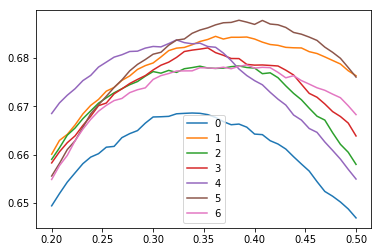

In [46]:
for i, val_proba_y in enumerate([o[1] for o in outputs]):
    f1_list = []
    for thr in np.linspace(0.2, 0.5, 40):
        f1_list.append(f1_score(val_proba_y > thr, val_y, pos_label=1))

    plt.plot(np.linspace(0.2, 0.5, 40), f1_list, label=i)

    print(max(f1_list))
    np.linspace(0.2, 0.5, 40)[np.argmax(f1_list)]
plt.legend()

In [59]:
val_proba_y = np.concatenate([o[1] for o in outputs], axis=1).mean(axis=1)
val_proba_y.shape

(261225,)

0.699160823083113


0.3538461538461538

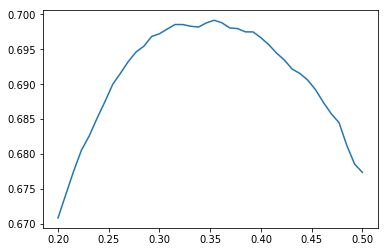

In [61]:
val_proba_y = np.concatenate([o[1] for o in outputs], axis=1).mean(axis=1)
f1_list = []
for thr in np.linspace(0.2, 0.5, 40):
    f1_list.append(f1_score(val_proba_y > thr, val_y, pos_label=1))

plt.plot(np.linspace(0.2, 0.5, 40), f1_list, label=i)

print(max(f1_list))
np.linspace(0.2, 0.5, 40)[np.argmax(f1_list)]

In [40]:
import optuna

In [65]:
pred_train_array = np.concatenate([o[0] for o in outputs], axis=1)

In [66]:
pred_val_array = np.concatenate([o[1] for o in outputs], axis=1)

In [53]:
def objective(trial):
    w_list = []
    for i in range(7):
        w_list.append(trial.suggest_uniform('w{}'.format(i), 0, 0.5))
    
    w_normed = np.array(w_list) / np.sum(w_list)
    
    val_proba_y = np.dot(pred_val_array, w_normed)
    
    f1_list = []
    for thr in np.linspace(0.2, 0.5, 40):
        f1_list.append(f1_score(val_proba_y > thr, val_y, pos_label=1))
    
    return - max(f1_list)

In [54]:
study = optuna.create_study()
    
study.optimize(objective, n_trials=1000)

[I 2018-12-23 16:36:44,835] Finished a trial resulted in value: -0.699252244709. Current best value is -0.699252244709 with parameters: {'w6': 0.4419550091417722, 'w5': 0.1472708393096016, 'w4': 0.48688182659431106, 'w3': 0.19915929025489404, 'w2': 0.2152814009076386, 'w1': 0.3106401584377696, 'w0': 0.20463796312714405}.
[I 2018-12-23 16:36:45,800] Finished a trial resulted in value: -0.698736805676. Current best value is -0.699252244709 with parameters: {'w6': 0.4419550091417722, 'w5': 0.1472708393096016, 'w4': 0.48688182659431106, 'w3': 0.19915929025489404, 'w2': 0.2152814009076386, 'w1': 0.3106401584377696, 'w0': 0.20463796312714405}.
[I 2018-12-23 16:36:46,816] Finished a trial resulted in value: -0.697737038098. Current best value is -0.699252244709 with parameters: {'w6': 0.4419550091417722, 'w5': 0.1472708393096016, 'w4': 0.48688182659431106, 'w3': 0.19915929025489404, 'w2': 0.2152814009076386, 'w1': 0.3106401584377696, 'w0': 0.20463796312714405}.
[I 2018-12-23 16:36:47,826] Fin

[I 2018-12-23 16:37:09,833] Finished a trial resulted in value: -0.699186053224. Current best value is -0.700134983773 with parameters: {'w6': 0.2698249676197936, 'w5': 0.35570671434618956, 'w4': 0.3216976622602283, 'w3': 0.3384343078054307, 'w2': 0.3052222416703337, 'w1': 0.41980261122268686, 'w0': 0.0018791918029127386}.
[I 2018-12-23 16:37:10,924] Finished a trial resulted in value: -0.699217210114. Current best value is -0.700134983773 with parameters: {'w6': 0.2698249676197936, 'w5': 0.35570671434618956, 'w4': 0.3216976622602283, 'w3': 0.3384343078054307, 'w2': 0.3052222416703337, 'w1': 0.41980261122268686, 'w0': 0.0018791918029127386}.
[I 2018-12-23 16:37:12,009] Finished a trial resulted in value: -0.698188661491. Current best value is -0.700134983773 with parameters: {'w6': 0.2698249676197936, 'w5': 0.35570671434618956, 'w4': 0.3216976622602283, 'w3': 0.3384343078054307, 'w2': 0.3052222416703337, 'w1': 0.41980261122268686, 'w0': 0.0018791918029127386}.
[I 2018-12-23 16:37:13,05

[I 2018-12-23 16:37:36,050] Finished a trial resulted in value: -0.698343304188. Current best value is -0.700281739231 with parameters: {'w6': 0.3273225797809958, 'w5': 0.4818307140609078, 'w4': 0.2306666791679397, 'w3': 0.12100442805105045, 'w2': 0.4134387671609496, 'w1': 0.3031019545114474, 'w0': 0.191841390467638}.
[I 2018-12-23 16:37:37,071] Finished a trial resulted in value: -0.699296298415. Current best value is -0.700281739231 with parameters: {'w6': 0.3273225797809958, 'w5': 0.4818307140609078, 'w4': 0.2306666791679397, 'w3': 0.12100442805105045, 'w2': 0.4134387671609496, 'w1': 0.3031019545114474, 'w0': 0.191841390467638}.
[I 2018-12-23 16:37:38,091] Finished a trial resulted in value: -0.699114535419. Current best value is -0.700281739231 with parameters: {'w6': 0.3273225797809958, 'w5': 0.4818307140609078, 'w4': 0.2306666791679397, 'w3': 0.12100442805105045, 'w2': 0.4134387671609496, 'w1': 0.3031019545114474, 'w0': 0.191841390467638}.
[I 2018-12-23 16:37:39,092] Finished a t

[I 2018-12-23 16:38:02,793] Finished a trial resulted in value: -0.699881581608. Current best value is -0.701157407407 with parameters: {'w6': 0.4379811685430832, 'w5': 0.39697281080371216, 'w4': 0.47051854263914855, 'w3': 0.14955549162585305, 'w2': 0.48006671377698334, 'w1': 0.45680233602607045, 'w0': 0.0299469272397053}.
[I 2018-12-23 16:38:03,904] Finished a trial resulted in value: -0.70010911388. Current best value is -0.701157407407 with parameters: {'w6': 0.4379811685430832, 'w5': 0.39697281080371216, 'w4': 0.47051854263914855, 'w3': 0.14955549162585305, 'w2': 0.48006671377698334, 'w1': 0.45680233602607045, 'w0': 0.0299469272397053}.
[I 2018-12-23 16:38:04,942] Finished a trial resulted in value: -0.699885974914. Current best value is -0.701157407407 with parameters: {'w6': 0.4379811685430832, 'w5': 0.39697281080371216, 'w4': 0.47051854263914855, 'w3': 0.14955549162585305, 'w2': 0.48006671377698334, 'w1': 0.45680233602607045, 'w0': 0.0299469272397053}.
[I 2018-12-23 16:38:06,046

[I 2018-12-23 16:38:29,736] Finished a trial resulted in value: -0.700434908669. Current best value is -0.701157407407 with parameters: {'w6': 0.4379811685430832, 'w5': 0.39697281080371216, 'w4': 0.47051854263914855, 'w3': 0.14955549162585305, 'w2': 0.48006671377698334, 'w1': 0.45680233602607045, 'w0': 0.0299469272397053}.
[I 2018-12-23 16:38:30,775] Finished a trial resulted in value: -0.697538134498. Current best value is -0.701157407407 with parameters: {'w6': 0.4379811685430832, 'w5': 0.39697281080371216, 'w4': 0.47051854263914855, 'w3': 0.14955549162585305, 'w2': 0.48006671377698334, 'w1': 0.45680233602607045, 'w0': 0.0299469272397053}.
[I 2018-12-23 16:38:31,816] Finished a trial resulted in value: -0.699244978129. Current best value is -0.701157407407 with parameters: {'w6': 0.4379811685430832, 'w5': 0.39697281080371216, 'w4': 0.47051854263914855, 'w3': 0.14955549162585305, 'w2': 0.48006671377698334, 'w1': 0.45680233602607045, 'w0': 0.0299469272397053}.
[I 2018-12-23 16:38:32,91

[I 2018-12-23 16:38:56,007] Finished a trial resulted in value: -0.699309016765. Current best value is -0.701157407407 with parameters: {'w6': 0.4379811685430832, 'w5': 0.39697281080371216, 'w4': 0.47051854263914855, 'w3': 0.14955549162585305, 'w2': 0.48006671377698334, 'w1': 0.45680233602607045, 'w0': 0.0299469272397053}.
[I 2018-12-23 16:38:57,075] Finished a trial resulted in value: -0.699259344319. Current best value is -0.701157407407 with parameters: {'w6': 0.4379811685430832, 'w5': 0.39697281080371216, 'w4': 0.47051854263914855, 'w3': 0.14955549162585305, 'w2': 0.48006671377698334, 'w1': 0.45680233602607045, 'w0': 0.0299469272397053}.
[I 2018-12-23 16:38:58,123] Finished a trial resulted in value: -0.699571925187. Current best value is -0.701157407407 with parameters: {'w6': 0.4379811685430832, 'w5': 0.39697281080371216, 'w4': 0.47051854263914855, 'w3': 0.14955549162585305, 'w2': 0.48006671377698334, 'w1': 0.45680233602607045, 'w0': 0.0299469272397053}.
[I 2018-12-23 16:38:59,17

[I 2018-12-23 16:39:22,498] Finished a trial resulted in value: -0.7004048583. Current best value is -0.701157407407 with parameters: {'w6': 0.4379811685430832, 'w5': 0.39697281080371216, 'w4': 0.47051854263914855, 'w3': 0.14955549162585305, 'w2': 0.48006671377698334, 'w1': 0.45680233602607045, 'w0': 0.0299469272397053}.
[I 2018-12-23 16:39:23,562] Finished a trial resulted in value: -0.700319452039. Current best value is -0.701157407407 with parameters: {'w6': 0.4379811685430832, 'w5': 0.39697281080371216, 'w4': 0.47051854263914855, 'w3': 0.14955549162585305, 'w2': 0.48006671377698334, 'w1': 0.45680233602607045, 'w0': 0.0299469272397053}.
[I 2018-12-23 16:39:24,625] Finished a trial resulted in value: -0.700251026928. Current best value is -0.701157407407 with parameters: {'w6': 0.4379811685430832, 'w5': 0.39697281080371216, 'w4': 0.47051854263914855, 'w3': 0.14955549162585305, 'w2': 0.48006671377698334, 'w1': 0.45680233602607045, 'w0': 0.0299469272397053}.
[I 2018-12-23 16:39:25,690]

[I 2018-12-23 16:39:49,408] Finished a trial resulted in value: -0.700077366114. Current best value is -0.701157407407 with parameters: {'w6': 0.4379811685430832, 'w5': 0.39697281080371216, 'w4': 0.47051854263914855, 'w3': 0.14955549162585305, 'w2': 0.48006671377698334, 'w1': 0.45680233602607045, 'w0': 0.0299469272397053}.
[I 2018-12-23 16:39:50,481] Finished a trial resulted in value: -0.699693623909. Current best value is -0.701157407407 with parameters: {'w6': 0.4379811685430832, 'w5': 0.39697281080371216, 'w4': 0.47051854263914855, 'w3': 0.14955549162585305, 'w2': 0.48006671377698334, 'w1': 0.45680233602607045, 'w0': 0.0299469272397053}.
[I 2018-12-23 16:39:51,555] Finished a trial resulted in value: -0.700477361493. Current best value is -0.701157407407 with parameters: {'w6': 0.4379811685430832, 'w5': 0.39697281080371216, 'w4': 0.47051854263914855, 'w3': 0.14955549162585305, 'w2': 0.48006671377698334, 'w1': 0.45680233602607045, 'w0': 0.0299469272397053}.
[I 2018-12-23 16:39:52,63

[I 2018-12-23 16:40:16,495] Finished a trial resulted in value: -0.700692292095. Current best value is -0.701157407407 with parameters: {'w6': 0.4379811685430832, 'w5': 0.39697281080371216, 'w4': 0.47051854263914855, 'w3': 0.14955549162585305, 'w2': 0.48006671377698334, 'w1': 0.45680233602607045, 'w0': 0.0299469272397053}.
[I 2018-12-23 16:40:17,583] Finished a trial resulted in value: -0.700463749748. Current best value is -0.701157407407 with parameters: {'w6': 0.4379811685430832, 'w5': 0.39697281080371216, 'w4': 0.47051854263914855, 'w3': 0.14955549162585305, 'w2': 0.48006671377698334, 'w1': 0.45680233602607045, 'w0': 0.0299469272397053}.
[I 2018-12-23 16:40:18,671] Finished a trial resulted in value: -0.699221677717. Current best value is -0.701157407407 with parameters: {'w6': 0.4379811685430832, 'w5': 0.39697281080371216, 'w4': 0.47051854263914855, 'w3': 0.14955549162585305, 'w2': 0.48006671377698334, 'w1': 0.45680233602607045, 'w0': 0.0299469272397053}.
[I 2018-12-23 16:40:19,75

[I 2018-12-23 16:40:43,761] Finished a trial resulted in value: -0.699462707262. Current best value is -0.701157407407 with parameters: {'w6': 0.4379811685430832, 'w5': 0.39697281080371216, 'w4': 0.47051854263914855, 'w3': 0.14955549162585305, 'w2': 0.48006671377698334, 'w1': 0.45680233602607045, 'w0': 0.0299469272397053}.
[I 2018-12-23 16:40:44,861] Finished a trial resulted in value: -0.698909324834. Current best value is -0.701157407407 with parameters: {'w6': 0.4379811685430832, 'w5': 0.39697281080371216, 'w4': 0.47051854263914855, 'w3': 0.14955549162585305, 'w2': 0.48006671377698334, 'w1': 0.45680233602607045, 'w0': 0.0299469272397053}.
[I 2018-12-23 16:40:45,955] Finished a trial resulted in value: -0.698870409264. Current best value is -0.701157407407 with parameters: {'w6': 0.4379811685430832, 'w5': 0.39697281080371216, 'w4': 0.47051854263914855, 'w3': 0.14955549162585305, 'w2': 0.48006671377698334, 'w1': 0.45680233602607045, 'w0': 0.0299469272397053}.
[I 2018-12-23 16:40:47,05

[I 2018-12-23 16:41:11,328] Finished a trial resulted in value: -0.700556134863. Current best value is -0.701157407407 with parameters: {'w6': 0.4379811685430832, 'w5': 0.39697281080371216, 'w4': 0.47051854263914855, 'w3': 0.14955549162585305, 'w2': 0.48006671377698334, 'w1': 0.45680233602607045, 'w0': 0.0299469272397053}.
[I 2018-12-23 16:41:12,435] Finished a trial resulted in value: -0.699398288087. Current best value is -0.701157407407 with parameters: {'w6': 0.4379811685430832, 'w5': 0.39697281080371216, 'w4': 0.47051854263914855, 'w3': 0.14955549162585305, 'w2': 0.48006671377698334, 'w1': 0.45680233602607045, 'w0': 0.0299469272397053}.
[I 2018-12-23 16:41:13,541] Finished a trial resulted in value: -0.699384414627. Current best value is -0.701157407407 with parameters: {'w6': 0.4379811685430832, 'w5': 0.39697281080371216, 'w4': 0.47051854263914855, 'w3': 0.14955549162585305, 'w2': 0.48006671377698334, 'w1': 0.45680233602607045, 'w0': 0.0299469272397053}.
[I 2018-12-23 16:41:14,64

[I 2018-12-23 16:41:39,273] Finished a trial resulted in value: -0.699985454545. Current best value is -0.701157407407 with parameters: {'w6': 0.4379811685430832, 'w5': 0.39697281080371216, 'w4': 0.47051854263914855, 'w3': 0.14955549162585305, 'w2': 0.48006671377698334, 'w1': 0.45680233602607045, 'w0': 0.0299469272397053}.
[I 2018-12-23 16:41:40,390] Finished a trial resulted in value: -0.700316924956. Current best value is -0.701157407407 with parameters: {'w6': 0.4379811685430832, 'w5': 0.39697281080371216, 'w4': 0.47051854263914855, 'w3': 0.14955549162585305, 'w2': 0.48006671377698334, 'w1': 0.45680233602607045, 'w0': 0.0299469272397053}.
[I 2018-12-23 16:41:41,507] Finished a trial resulted in value: -0.700142222738. Current best value is -0.701157407407 with parameters: {'w6': 0.4379811685430832, 'w5': 0.39697281080371216, 'w4': 0.47051854263914855, 'w3': 0.14955549162585305, 'w2': 0.48006671377698334, 'w1': 0.45680233602607045, 'w0': 0.0299469272397053}.
[I 2018-12-23 16:41:42,62

[I 2018-12-23 16:42:07,651] Finished a trial resulted in value: -0.700821569081. Current best value is -0.701157407407 with parameters: {'w6': 0.4379811685430832, 'w5': 0.39697281080371216, 'w4': 0.47051854263914855, 'w3': 0.14955549162585305, 'w2': 0.48006671377698334, 'w1': 0.45680233602607045, 'w0': 0.0299469272397053}.
[I 2018-12-23 16:42:08,783] Finished a trial resulted in value: -0.699769186382. Current best value is -0.701157407407 with parameters: {'w6': 0.4379811685430832, 'w5': 0.39697281080371216, 'w4': 0.47051854263914855, 'w3': 0.14955549162585305, 'w2': 0.48006671377698334, 'w1': 0.45680233602607045, 'w0': 0.0299469272397053}.
[I 2018-12-23 16:42:09,913] Finished a trial resulted in value: -0.69994564751. Current best value is -0.701157407407 with parameters: {'w6': 0.4379811685430832, 'w5': 0.39697281080371216, 'w4': 0.47051854263914855, 'w3': 0.14955549162585305, 'w2': 0.48006671377698334, 'w1': 0.45680233602607045, 'w0': 0.0299469272397053}.
[I 2018-12-23 16:42:11,051

[I 2018-12-23 16:42:36,560] Finished a trial resulted in value: -0.700552870003. Current best value is -0.701157407407 with parameters: {'w6': 0.4379811685430832, 'w5': 0.39697281080371216, 'w4': 0.47051854263914855, 'w3': 0.14955549162585305, 'w2': 0.48006671377698334, 'w1': 0.45680233602607045, 'w0': 0.0299469272397053}.
[I 2018-12-23 16:42:37,709] Finished a trial resulted in value: -0.699956553222. Current best value is -0.701157407407 with parameters: {'w6': 0.4379811685430832, 'w5': 0.39697281080371216, 'w4': 0.47051854263914855, 'w3': 0.14955549162585305, 'w2': 0.48006671377698334, 'w1': 0.45680233602607045, 'w0': 0.0299469272397053}.
[I 2018-12-23 16:42:38,850] Finished a trial resulted in value: -0.699904731661. Current best value is -0.701157407407 with parameters: {'w6': 0.4379811685430832, 'w5': 0.39697281080371216, 'w4': 0.47051854263914855, 'w3': 0.14955549162585305, 'w2': 0.48006671377698334, 'w1': 0.45680233602607045, 'w0': 0.0299469272397053}.
[I 2018-12-23 16:42:39,99

[I 2018-12-23 16:43:05,306] Finished a trial resulted in value: -0.698600275356. Current best value is -0.701157407407 with parameters: {'w6': 0.4379811685430832, 'w5': 0.39697281080371216, 'w4': 0.47051854263914855, 'w3': 0.14955549162585305, 'w2': 0.48006671377698334, 'w1': 0.45680233602607045, 'w0': 0.0299469272397053}.
[I 2018-12-23 16:43:06,462] Finished a trial resulted in value: -0.700452278789. Current best value is -0.701157407407 with parameters: {'w6': 0.4379811685430832, 'w5': 0.39697281080371216, 'w4': 0.47051854263914855, 'w3': 0.14955549162585305, 'w2': 0.48006671377698334, 'w1': 0.45680233602607045, 'w0': 0.0299469272397053}.
[I 2018-12-23 16:43:07,618] Finished a trial resulted in value: -0.700162074554. Current best value is -0.701157407407 with parameters: {'w6': 0.4379811685430832, 'w5': 0.39697281080371216, 'w4': 0.47051854263914855, 'w3': 0.14955549162585305, 'w2': 0.48006671377698334, 'w1': 0.45680233602607045, 'w0': 0.0299469272397053}.
[I 2018-12-23 16:43:08,78

[I 2018-12-23 16:43:34,448] Finished a trial resulted in value: -0.700449153518. Current best value is -0.701157407407 with parameters: {'w6': 0.4379811685430832, 'w5': 0.39697281080371216, 'w4': 0.47051854263914855, 'w3': 0.14955549162585305, 'w2': 0.48006671377698334, 'w1': 0.45680233602607045, 'w0': 0.0299469272397053}.
[I 2018-12-23 16:43:35,622] Finished a trial resulted in value: -0.700530573193. Current best value is -0.701157407407 with parameters: {'w6': 0.4379811685430832, 'w5': 0.39697281080371216, 'w4': 0.47051854263914855, 'w3': 0.14955549162585305, 'w2': 0.48006671377698334, 'w1': 0.45680233602607045, 'w0': 0.0299469272397053}.
[I 2018-12-23 16:43:36,788] Finished a trial resulted in value: -0.7. Current best value is -0.701157407407 with parameters: {'w6': 0.4379811685430832, 'w5': 0.39697281080371216, 'w4': 0.47051854263914855, 'w3': 0.14955549162585305, 'w2': 0.48006671377698334, 'w1': 0.45680233602607045, 'w0': 0.0299469272397053}.
[I 2018-12-23 16:43:37,956] Finished

[I 2018-12-23 16:44:03,822] Finished a trial resulted in value: -0.700505863417. Current best value is -0.701157407407 with parameters: {'w6': 0.4379811685430832, 'w5': 0.39697281080371216, 'w4': 0.47051854263914855, 'w3': 0.14955549162585305, 'w2': 0.48006671377698334, 'w1': 0.45680233602607045, 'w0': 0.0299469272397053}.
[I 2018-12-23 16:44:05,000] Finished a trial resulted in value: -0.700673001935. Current best value is -0.701157407407 with parameters: {'w6': 0.4379811685430832, 'w5': 0.39697281080371216, 'w4': 0.47051854263914855, 'w3': 0.14955549162585305, 'w2': 0.48006671377698334, 'w1': 0.45680233602607045, 'w0': 0.0299469272397053}.
[I 2018-12-23 16:44:06,183] Finished a trial resulted in value: -0.700770807471. Current best value is -0.701157407407 with parameters: {'w6': 0.4379811685430832, 'w5': 0.39697281080371216, 'w4': 0.47051854263914855, 'w3': 0.14955549162585305, 'w2': 0.48006671377698334, 'w1': 0.45680233602607045, 'w0': 0.0299469272397053}.
[I 2018-12-23 16:44:07,36

[I 2018-12-23 16:44:33,621] Finished a trial resulted in value: -0.700505853447. Current best value is -0.701157407407 with parameters: {'w6': 0.4379811685430832, 'w5': 0.39697281080371216, 'w4': 0.47051854263914855, 'w3': 0.14955549162585305, 'w2': 0.48006671377698334, 'w1': 0.45680233602607045, 'w0': 0.0299469272397053}.
[I 2018-12-23 16:44:34,822] Finished a trial resulted in value: -0.700734146482. Current best value is -0.701157407407 with parameters: {'w6': 0.4379811685430832, 'w5': 0.39697281080371216, 'w4': 0.47051854263914855, 'w3': 0.14955549162585305, 'w2': 0.48006671377698334, 'w1': 0.45680233602607045, 'w0': 0.0299469272397053}.
[I 2018-12-23 16:44:36,102] Finished a trial resulted in value: -0.700509367176. Current best value is -0.701157407407 with parameters: {'w6': 0.4379811685430832, 'w5': 0.39697281080371216, 'w4': 0.47051854263914855, 'w3': 0.14955549162585305, 'w2': 0.48006671377698334, 'w1': 0.45680233602607045, 'w0': 0.0299469272397053}.
[I 2018-12-23 16:44:37,30

[I 2018-12-23 16:45:03,917] Finished a trial resulted in value: -0.700208429829. Current best value is -0.701157407407 with parameters: {'w6': 0.4379811685430832, 'w5': 0.39697281080371216, 'w4': 0.47051854263914855, 'w3': 0.14955549162585305, 'w2': 0.48006671377698334, 'w1': 0.45680233602607045, 'w0': 0.0299469272397053}.
[I 2018-12-23 16:45:05,118] Finished a trial resulted in value: -0.700396997885. Current best value is -0.701157407407 with parameters: {'w6': 0.4379811685430832, 'w5': 0.39697281080371216, 'w4': 0.47051854263914855, 'w3': 0.14955549162585305, 'w2': 0.48006671377698334, 'w1': 0.45680233602607045, 'w0': 0.0299469272397053}.
[I 2018-12-23 16:45:06,331] Finished a trial resulted in value: -0.700159166546. Current best value is -0.701157407407 with parameters: {'w6': 0.4379811685430832, 'w5': 0.39697281080371216, 'w4': 0.47051854263914855, 'w3': 0.14955549162585305, 'w2': 0.48006671377698334, 'w1': 0.45680233602607045, 'w0': 0.0299469272397053}.
[I 2018-12-23 16:45:07,53

[I 2018-12-23 16:45:34,474] Finished a trial resulted in value: -0.699348487042. Current best value is -0.701157407407 with parameters: {'w6': 0.4379811685430832, 'w5': 0.39697281080371216, 'w4': 0.47051854263914855, 'w3': 0.14955549162585305, 'w2': 0.48006671377698334, 'w1': 0.45680233602607045, 'w0': 0.0299469272397053}.
[I 2018-12-23 16:45:35,708] Finished a trial resulted in value: -0.700266790396. Current best value is -0.701157407407 with parameters: {'w6': 0.4379811685430832, 'w5': 0.39697281080371216, 'w4': 0.47051854263914855, 'w3': 0.14955549162585305, 'w2': 0.48006671377698334, 'w1': 0.45680233602607045, 'w0': 0.0299469272397053}.
[I 2018-12-23 16:45:37,045] Finished a trial resulted in value: -0.700567249273. Current best value is -0.701157407407 with parameters: {'w6': 0.4379811685430832, 'w5': 0.39697281080371216, 'w4': 0.47051854263914855, 'w3': 0.14955549162585305, 'w2': 0.48006671377698334, 'w1': 0.45680233602607045, 'w0': 0.0299469272397053}.
[I 2018-12-23 16:45:38,25

[I 2018-12-23 16:46:05,295] Finished a trial resulted in value: -0.700555170021. Current best value is -0.701157407407 with parameters: {'w6': 0.4379811685430832, 'w5': 0.39697281080371216, 'w4': 0.47051854263914855, 'w3': 0.14955549162585305, 'w2': 0.48006671377698334, 'w1': 0.45680233602607045, 'w0': 0.0299469272397053}.
[I 2018-12-23 16:46:06,525] Finished a trial resulted in value: -0.699328396763. Current best value is -0.701157407407 with parameters: {'w6': 0.4379811685430832, 'w5': 0.39697281080371216, 'w4': 0.47051854263914855, 'w3': 0.14955549162585305, 'w2': 0.48006671377698334, 'w1': 0.45680233602607045, 'w0': 0.0299469272397053}.
[I 2018-12-23 16:46:07,753] Finished a trial resulted in value: -0.700574430621. Current best value is -0.701157407407 with parameters: {'w6': 0.4379811685430832, 'w5': 0.39697281080371216, 'w4': 0.47051854263914855, 'w3': 0.14955549162585305, 'w2': 0.48006671377698334, 'w1': 0.45680233602607045, 'w0': 0.0299469272397053}.
[I 2018-12-23 16:46:08,98

[I 2018-12-23 16:46:36,567] Finished a trial resulted in value: -0.700505561173. Current best value is -0.701157407407 with parameters: {'w6': 0.4379811685430832, 'w5': 0.39697281080371216, 'w4': 0.47051854263914855, 'w3': 0.14955549162585305, 'w2': 0.48006671377698334, 'w1': 0.45680233602607045, 'w0': 0.0299469272397053}.
[I 2018-12-23 16:46:37,802] Finished a trial resulted in value: -0.699904621521. Current best value is -0.701157407407 with parameters: {'w6': 0.4379811685430832, 'w5': 0.39697281080371216, 'w4': 0.47051854263914855, 'w3': 0.14955549162585305, 'w2': 0.48006671377698334, 'w1': 0.45680233602607045, 'w0': 0.0299469272397053}.
[I 2018-12-23 16:46:39,045] Finished a trial resulted in value: -0.699065949618. Current best value is -0.701157407407 with parameters: {'w6': 0.4379811685430832, 'w5': 0.39697281080371216, 'w4': 0.47051854263914855, 'w3': 0.14955549162585305, 'w2': 0.48006671377698334, 'w1': 0.45680233602607045, 'w0': 0.0299469272397053}.
[I 2018-12-23 16:46:40,28

[I 2018-12-23 16:47:08,070] Finished a trial resulted in value: -0.699872655707. Current best value is -0.701157407407 with parameters: {'w6': 0.4379811685430832, 'w5': 0.39697281080371216, 'w4': 0.47051854263914855, 'w3': 0.14955549162585305, 'w2': 0.48006671377698334, 'w1': 0.45680233602607045, 'w0': 0.0299469272397053}.
[I 2018-12-23 16:47:09,321] Finished a trial resulted in value: -0.700603819374. Current best value is -0.701157407407 with parameters: {'w6': 0.4379811685430832, 'w5': 0.39697281080371216, 'w4': 0.47051854263914855, 'w3': 0.14955549162585305, 'w2': 0.48006671377698334, 'w1': 0.45680233602607045, 'w0': 0.0299469272397053}.
[I 2018-12-23 16:47:10,584] Finished a trial resulted in value: -0.698888158459. Current best value is -0.701157407407 with parameters: {'w6': 0.4379811685430832, 'w5': 0.39697281080371216, 'w4': 0.47051854263914855, 'w3': 0.14955549162585305, 'w2': 0.48006671377698334, 'w1': 0.45680233602607045, 'w0': 0.0299469272397053}.
[I 2018-12-23 16:47:11,84

[I 2018-12-23 16:47:40,070] Finished a trial resulted in value: -0.700451232211. Current best value is -0.701157407407 with parameters: {'w6': 0.4379811685430832, 'w5': 0.39697281080371216, 'w4': 0.47051854263914855, 'w3': 0.14955549162585305, 'w2': 0.48006671377698334, 'w1': 0.45680233602607045, 'w0': 0.0299469272397053}.
[I 2018-12-23 16:47:41,327] Finished a trial resulted in value: -0.698510204667. Current best value is -0.701157407407 with parameters: {'w6': 0.4379811685430832, 'w5': 0.39697281080371216, 'w4': 0.47051854263914855, 'w3': 0.14955549162585305, 'w2': 0.48006671377698334, 'w1': 0.45680233602607045, 'w0': 0.0299469272397053}.
[I 2018-12-23 16:47:42,590] Finished a trial resulted in value: -0.700911062907. Current best value is -0.701157407407 with parameters: {'w6': 0.4379811685430832, 'w5': 0.39697281080371216, 'w4': 0.47051854263914855, 'w3': 0.14955549162585305, 'w2': 0.48006671377698334, 'w1': 0.45680233602607045, 'w0': 0.0299469272397053}.
[I 2018-12-23 16:47:43,86

[I 2018-12-23 16:48:12,684] Finished a trial resulted in value: -0.700681844447. Current best value is -0.701157407407 with parameters: {'w6': 0.4379811685430832, 'w5': 0.39697281080371216, 'w4': 0.47051854263914855, 'w3': 0.14955549162585305, 'w2': 0.48006671377698334, 'w1': 0.45680233602607045, 'w0': 0.0299469272397053}.
[I 2018-12-23 16:48:14,035] Finished a trial resulted in value: -0.700467748455. Current best value is -0.701157407407 with parameters: {'w6': 0.4379811685430832, 'w5': 0.39697281080371216, 'w4': 0.47051854263914855, 'w3': 0.14955549162585305, 'w2': 0.48006671377698334, 'w1': 0.45680233602607045, 'w0': 0.0299469272397053}.
[I 2018-12-23 16:48:15,397] Finished a trial resulted in value: -0.700826541818. Current best value is -0.701157407407 with parameters: {'w6': 0.4379811685430832, 'w5': 0.39697281080371216, 'w4': 0.47051854263914855, 'w3': 0.14955549162585305, 'w2': 0.48006671377698334, 'w1': 0.45680233602607045, 'w0': 0.0299469272397053}.
[I 2018-12-23 16:48:16,73

[I 2018-12-23 16:48:45,699] Finished a trial resulted in value: -0.700813896638. Current best value is -0.701185999421 with parameters: {'w6': 0.3657319415284667, 'w5': 0.42679036533697345, 'w4': 0.4060613518040133, 'w3': 0.1988938098591737, 'w2': 0.4997537087578329, 'w1': 0.41646552051229996, 'w0': 0.01818150855871833}.
[I 2018-12-23 16:48:47,081] Finished a trial resulted in value: -0.700606548423. Current best value is -0.701185999421 with parameters: {'w6': 0.3657319415284667, 'w5': 0.42679036533697345, 'w4': 0.4060613518040133, 'w3': 0.1988938098591737, 'w2': 0.4997537087578329, 'w1': 0.41646552051229996, 'w0': 0.01818150855871833}.
[I 2018-12-23 16:48:48,484] Finished a trial resulted in value: -0.699789619297. Current best value is -0.701185999421 with parameters: {'w6': 0.3657319415284667, 'w5': 0.42679036533697345, 'w4': 0.4060613518040133, 'w3': 0.1988938098591737, 'w2': 0.4997537087578329, 'w1': 0.41646552051229996, 'w0': 0.01818150855871833}.
[I 2018-12-23 16:48:49,807] Fin

[I 2018-12-23 16:49:18,763] Finished a trial resulted in value: -0.700906694476. Current best value is -0.701185999421 with parameters: {'w6': 0.3657319415284667, 'w5': 0.42679036533697345, 'w4': 0.4060613518040133, 'w3': 0.1988938098591737, 'w2': 0.4997537087578329, 'w1': 0.41646552051229996, 'w0': 0.01818150855871833}.
[I 2018-12-23 16:49:20,253] Finished a trial resulted in value: -0.700691891266. Current best value is -0.701185999421 with parameters: {'w6': 0.3657319415284667, 'w5': 0.42679036533697345, 'w4': 0.4060613518040133, 'w3': 0.1988938098591737, 'w2': 0.4997537087578329, 'w1': 0.41646552051229996, 'w0': 0.01818150855871833}.
[I 2018-12-23 16:49:21,619] Finished a trial resulted in value: -0.699777527376. Current best value is -0.701185999421 with parameters: {'w6': 0.3657319415284667, 'w5': 0.42679036533697345, 'w4': 0.4060613518040133, 'w3': 0.1988938098591737, 'w2': 0.4997537087578329, 'w1': 0.41646552051229996, 'w0': 0.01818150855871833}.
[I 2018-12-23 16:49:22,965] Fin

[I 2018-12-23 16:49:52,203] Finished a trial resulted in value: -0.701075020229. Current best value is -0.701185999421 with parameters: {'w6': 0.3657319415284667, 'w5': 0.42679036533697345, 'w4': 0.4060613518040133, 'w3': 0.1988938098591737, 'w2': 0.4997537087578329, 'w1': 0.41646552051229996, 'w0': 0.01818150855871833}.
[I 2018-12-23 16:49:53,558] Finished a trial resulted in value: -0.700846307155. Current best value is -0.701185999421 with parameters: {'w6': 0.3657319415284667, 'w5': 0.42679036533697345, 'w4': 0.4060613518040133, 'w3': 0.1988938098591737, 'w2': 0.4997537087578329, 'w1': 0.41646552051229996, 'w0': 0.01818150855871833}.
[I 2018-12-23 16:49:54,886] Finished a trial resulted in value: -0.699288101119. Current best value is -0.701185999421 with parameters: {'w6': 0.3657319415284667, 'w5': 0.42679036533697345, 'w4': 0.4060613518040133, 'w3': 0.1988938098591737, 'w2': 0.4997537087578329, 'w1': 0.41646552051229996, 'w0': 0.01818150855871833}.
[I 2018-12-23 16:49:56,202] Fin

[I 2018-12-23 16:50:25,412] Finished a trial resulted in value: -0.700132557201. Current best value is -0.701185999421 with parameters: {'w6': 0.3657319415284667, 'w5': 0.42679036533697345, 'w4': 0.4060613518040133, 'w3': 0.1988938098591737, 'w2': 0.4997537087578329, 'w1': 0.41646552051229996, 'w0': 0.01818150855871833}.
[I 2018-12-23 16:50:26,754] Finished a trial resulted in value: -0.699476135041. Current best value is -0.701185999421 with parameters: {'w6': 0.3657319415284667, 'w5': 0.42679036533697345, 'w4': 0.4060613518040133, 'w3': 0.1988938098591737, 'w2': 0.4997537087578329, 'w1': 0.41646552051229996, 'w0': 0.01818150855871833}.
[I 2018-12-23 16:50:28,104] Finished a trial resulted in value: -0.700506146059. Current best value is -0.701185999421 with parameters: {'w6': 0.3657319415284667, 'w5': 0.42679036533697345, 'w4': 0.4060613518040133, 'w3': 0.1988938098591737, 'w2': 0.4997537087578329, 'w1': 0.41646552051229996, 'w0': 0.01818150855871833}.
[I 2018-12-23 16:50:29,458] Fin

[I 2018-12-23 16:50:59,606] Finished a trial resulted in value: -0.699318325027. Current best value is -0.701185999421 with parameters: {'w6': 0.3657319415284667, 'w5': 0.42679036533697345, 'w4': 0.4060613518040133, 'w3': 0.1988938098591737, 'w2': 0.4997537087578329, 'w1': 0.41646552051229996, 'w0': 0.01818150855871833}.
[I 2018-12-23 16:51:00,954] Finished a trial resulted in value: -0.700563014292. Current best value is -0.701185999421 with parameters: {'w6': 0.3657319415284667, 'w5': 0.42679036533697345, 'w4': 0.4060613518040133, 'w3': 0.1988938098591737, 'w2': 0.4997537087578329, 'w1': 0.41646552051229996, 'w0': 0.01818150855871833}.
[I 2018-12-23 16:51:02,294] Finished a trial resulted in value: -0.700492980079. Current best value is -0.701185999421 with parameters: {'w6': 0.3657319415284667, 'w5': 0.42679036533697345, 'w4': 0.4060613518040133, 'w3': 0.1988938098591737, 'w2': 0.4997537087578329, 'w1': 0.41646552051229996, 'w0': 0.01818150855871833}.
[I 2018-12-23 16:51:03,641] Fin

[I 2018-12-23 16:51:33,432] Finished a trial resulted in value: -0.700384381954. Current best value is -0.701185999421 with parameters: {'w6': 0.3657319415284667, 'w5': 0.42679036533697345, 'w4': 0.4060613518040133, 'w3': 0.1988938098591737, 'w2': 0.4997537087578329, 'w1': 0.41646552051229996, 'w0': 0.01818150855871833}.
[I 2018-12-23 16:51:34,796] Finished a trial resulted in value: -0.700433820783. Current best value is -0.701185999421 with parameters: {'w6': 0.3657319415284667, 'w5': 0.42679036533697345, 'w4': 0.4060613518040133, 'w3': 0.1988938098591737, 'w2': 0.4997537087578329, 'w1': 0.41646552051229996, 'w0': 0.01818150855871833}.
[I 2018-12-23 16:51:36,155] Finished a trial resulted in value: -0.699184218754. Current best value is -0.701185999421 with parameters: {'w6': 0.3657319415284667, 'w5': 0.42679036533697345, 'w4': 0.4060613518040133, 'w3': 0.1988938098591737, 'w2': 0.4997537087578329, 'w1': 0.41646552051229996, 'w0': 0.01818150855871833}.
[I 2018-12-23 16:51:37,520] Fin

[I 2018-12-23 16:52:07,669] Finished a trial resulted in value: -0.700988729065. Current best value is -0.701185999421 with parameters: {'w6': 0.3657319415284667, 'w5': 0.42679036533697345, 'w4': 0.4060613518040133, 'w3': 0.1988938098591737, 'w2': 0.4997537087578329, 'w1': 0.41646552051229996, 'w0': 0.01818150855871833}.
[I 2018-12-23 16:52:09,044] Finished a trial resulted in value: -0.700305634046. Current best value is -0.701185999421 with parameters: {'w6': 0.3657319415284667, 'w5': 0.42679036533697345, 'w4': 0.4060613518040133, 'w3': 0.1988938098591737, 'w2': 0.4997537087578329, 'w1': 0.41646552051229996, 'w0': 0.01818150855871833}.
[I 2018-12-23 16:52:10,420] Finished a trial resulted in value: -0.699727709866. Current best value is -0.701185999421 with parameters: {'w6': 0.3657319415284667, 'w5': 0.42679036533697345, 'w4': 0.4060613518040133, 'w3': 0.1988938098591737, 'w2': 0.4997537087578329, 'w1': 0.41646552051229996, 'w0': 0.01818150855871833}.
[I 2018-12-23 16:52:11,803] Fin

[I 2018-12-23 16:52:42,347] Finished a trial resulted in value: -0.700629551191. Current best value is -0.701333333333 with parameters: {'w6': 0.3249454356283301, 'w5': 0.34883570706292344, 'w4': 0.4936136177257468, 'w3': 0.2039592076906438, 'w2': 0.46703558108997706, 'w1': 0.4903882707465285, 'w0': 0.02263612770216065}.
[I 2018-12-23 16:52:43,726] Finished a trial resulted in value: -0.700356821676. Current best value is -0.701333333333 with parameters: {'w6': 0.3249454356283301, 'w5': 0.34883570706292344, 'w4': 0.4936136177257468, 'w3': 0.2039592076906438, 'w2': 0.46703558108997706, 'w1': 0.4903882707465285, 'w0': 0.02263612770216065}.
[I 2018-12-23 16:52:45,127] Finished a trial resulted in value: -0.700739666425. Current best value is -0.701333333333 with parameters: {'w6': 0.3249454356283301, 'w5': 0.34883570706292344, 'w4': 0.4936136177257468, 'w3': 0.2039592076906438, 'w2': 0.46703558108997706, 'w1': 0.4903882707465285, 'w0': 0.02263612770216065}.
[I 2018-12-23 16:52:46,537] Fin

[I 2018-12-23 16:53:17,448] Finished a trial resulted in value: -0.700889880866. Current best value is -0.701333333333 with parameters: {'w6': 0.3249454356283301, 'w5': 0.34883570706292344, 'w4': 0.4936136177257468, 'w3': 0.2039592076906438, 'w2': 0.46703558108997706, 'w1': 0.4903882707465285, 'w0': 0.02263612770216065}.
[I 2018-12-23 16:53:18,865] Finished a trial resulted in value: -0.700837851158. Current best value is -0.701333333333 with parameters: {'w6': 0.3249454356283301, 'w5': 0.34883570706292344, 'w4': 0.4936136177257468, 'w3': 0.2039592076906438, 'w2': 0.46703558108997706, 'w1': 0.4903882707465285, 'w0': 0.02263612770216065}.
[I 2018-12-23 16:53:20,265] Finished a trial resulted in value: -0.70065684771. Current best value is -0.701333333333 with parameters: {'w6': 0.3249454356283301, 'w5': 0.34883570706292344, 'w4': 0.4936136177257468, 'w3': 0.2039592076906438, 'w2': 0.46703558108997706, 'w1': 0.4903882707465285, 'w0': 0.02263612770216065}.
[I 2018-12-23 16:53:21,692] Fini

[I 2018-12-23 16:53:53,029] Finished a trial resulted in value: -0.700648748842. Current best value is -0.701333333333 with parameters: {'w6': 0.3249454356283301, 'w5': 0.34883570706292344, 'w4': 0.4936136177257468, 'w3': 0.2039592076906438, 'w2': 0.46703558108997706, 'w1': 0.4903882707465285, 'w0': 0.02263612770216065}.
[I 2018-12-23 16:53:54,466] Finished a trial resulted in value: -0.700597413143. Current best value is -0.701333333333 with parameters: {'w6': 0.3249454356283301, 'w5': 0.34883570706292344, 'w4': 0.4936136177257468, 'w3': 0.2039592076906438, 'w2': 0.46703558108997706, 'w1': 0.4903882707465285, 'w0': 0.02263612770216065}.
[I 2018-12-23 16:53:55,891] Finished a trial resulted in value: -0.700566922789. Current best value is -0.701333333333 with parameters: {'w6': 0.3249454356283301, 'w5': 0.34883570706292344, 'w4': 0.4936136177257468, 'w3': 0.2039592076906438, 'w2': 0.46703558108997706, 'w1': 0.4903882707465285, 'w0': 0.02263612770216065}.
[I 2018-12-23 16:53:57,334] Fin

[I 2018-12-23 16:54:29,019] Finished a trial resulted in value: -0.700713956702. Current best value is -0.701333333333 with parameters: {'w6': 0.3249454356283301, 'w5': 0.34883570706292344, 'w4': 0.4936136177257468, 'w3': 0.2039592076906438, 'w2': 0.46703558108997706, 'w1': 0.4903882707465285, 'w0': 0.02263612770216065}.
[I 2018-12-23 16:54:30,675] Finished a trial resulted in value: -0.70090809185. Current best value is -0.701333333333 with parameters: {'w6': 0.3249454356283301, 'w5': 0.34883570706292344, 'w4': 0.4936136177257468, 'w3': 0.2039592076906438, 'w2': 0.46703558108997706, 'w1': 0.4903882707465285, 'w0': 0.02263612770216065}.
[I 2018-12-23 16:54:32,116] Finished a trial resulted in value: -0.700370842508. Current best value is -0.701333333333 with parameters: {'w6': 0.3249454356283301, 'w5': 0.34883570706292344, 'w4': 0.4936136177257468, 'w3': 0.2039592076906438, 'w2': 0.46703558108997706, 'w1': 0.4903882707465285, 'w0': 0.02263612770216065}.
[I 2018-12-23 16:54:33,572] Fini

[I 2018-12-23 16:55:06,013] Finished a trial resulted in value: -0.700347826087. Current best value is -0.701333333333 with parameters: {'w6': 0.3249454356283301, 'w5': 0.34883570706292344, 'w4': 0.4936136177257468, 'w3': 0.2039592076906438, 'w2': 0.46703558108997706, 'w1': 0.4903882707465285, 'w0': 0.02263612770216065}.
[I 2018-12-23 16:55:07,460] Finished a trial resulted in value: -0.700081642174. Current best value is -0.701333333333 with parameters: {'w6': 0.3249454356283301, 'w5': 0.34883570706292344, 'w4': 0.4936136177257468, 'w3': 0.2039592076906438, 'w2': 0.46703558108997706, 'w1': 0.4903882707465285, 'w0': 0.02263612770216065}.
[I 2018-12-23 16:55:08,902] Finished a trial resulted in value: -0.700312355391. Current best value is -0.701333333333 with parameters: {'w6': 0.3249454356283301, 'w5': 0.34883570706292344, 'w4': 0.4936136177257468, 'w3': 0.2039592076906438, 'w2': 0.46703558108997706, 'w1': 0.4903882707465285, 'w0': 0.02263612770216065}.
[I 2018-12-23 16:55:10,344] Fin

[I 2018-12-23 16:55:42,434] Finished a trial resulted in value: -0.700090413276. Current best value is -0.701333333333 with parameters: {'w6': 0.3249454356283301, 'w5': 0.34883570706292344, 'w4': 0.4936136177257468, 'w3': 0.2039592076906438, 'w2': 0.46703558108997706, 'w1': 0.4903882707465285, 'w0': 0.02263612770216065}.
[I 2018-12-23 16:55:43,877] Finished a trial resulted in value: -0.700034380014. Current best value is -0.701333333333 with parameters: {'w6': 0.3249454356283301, 'w5': 0.34883570706292344, 'w4': 0.4936136177257468, 'w3': 0.2039592076906438, 'w2': 0.46703558108997706, 'w1': 0.4903882707465285, 'w0': 0.02263612770216065}.
[I 2018-12-23 16:55:45,367] Finished a trial resulted in value: -0.699644821265. Current best value is -0.701333333333 with parameters: {'w6': 0.3249454356283301, 'w5': 0.34883570706292344, 'w4': 0.4936136177257468, 'w3': 0.2039592076906438, 'w2': 0.46703558108997706, 'w1': 0.4903882707465285, 'w0': 0.02263612770216065}.
[I 2018-12-23 16:55:46,850] Fin

[I 2018-12-23 16:56:18,962] Finished a trial resulted in value: -0.700724847782. Current best value is -0.701333333333 with parameters: {'w6': 0.3249454356283301, 'w5': 0.34883570706292344, 'w4': 0.4936136177257468, 'w3': 0.2039592076906438, 'w2': 0.46703558108997706, 'w1': 0.4903882707465285, 'w0': 0.02263612770216065}.
[I 2018-12-23 16:56:20,416] Finished a trial resulted in value: -0.700856184195. Current best value is -0.701333333333 with parameters: {'w6': 0.3249454356283301, 'w5': 0.34883570706292344, 'w4': 0.4936136177257468, 'w3': 0.2039592076906438, 'w2': 0.46703558108997706, 'w1': 0.4903882707465285, 'w0': 0.02263612770216065}.
[I 2018-12-23 16:56:21,871] Finished a trial resulted in value: -0.700807688967. Current best value is -0.701333333333 with parameters: {'w6': 0.3249454356283301, 'w5': 0.34883570706292344, 'w4': 0.4936136177257468, 'w3': 0.2039592076906438, 'w2': 0.46703558108997706, 'w1': 0.4903882707465285, 'w0': 0.02263612770216065}.
[I 2018-12-23 16:56:23,334] Fin

[I 2018-12-23 16:56:55,809] Finished a trial resulted in value: -0.699631467456. Current best value is -0.701333333333 with parameters: {'w6': 0.3249454356283301, 'w5': 0.34883570706292344, 'w4': 0.4936136177257468, 'w3': 0.2039592076906438, 'w2': 0.46703558108997706, 'w1': 0.4903882707465285, 'w0': 0.02263612770216065}.
[I 2018-12-23 16:56:57,283] Finished a trial resulted in value: -0.700313101428. Current best value is -0.701333333333 with parameters: {'w6': 0.3249454356283301, 'w5': 0.34883570706292344, 'w4': 0.4936136177257468, 'w3': 0.2039592076906438, 'w2': 0.46703558108997706, 'w1': 0.4903882707465285, 'w0': 0.02263612770216065}.
[I 2018-12-23 16:56:58,762] Finished a trial resulted in value: -0.700040535063. Current best value is -0.701333333333 with parameters: {'w6': 0.3249454356283301, 'w5': 0.34883570706292344, 'w4': 0.4936136177257468, 'w3': 0.2039592076906438, 'w2': 0.46703558108997706, 'w1': 0.4903882707465285, 'w0': 0.02263612770216065}.
[I 2018-12-23 16:57:00,359] Fin

In [62]:
study.best_params

{'w0': 0.02263612770216065,
 'w1': 0.4903882707465285,
 'w2': 0.46703558108997706,
 'w3': 0.2039592076906438,
 'w4': 0.4936136177257468,
 'w5': 0.34883570706292344,
 'w6': 0.3249454356283301}

In [68]:
weights = [study.best_params['w{}'.format(i)] for i in range(7)]
w_normed = np.array(weights) / np.sum(weights)
w_normed

array([0.0096266 , 0.20855038, 0.19861904, 0.08673896, 0.20992204,
       0.14835147, 0.13819151])

In [67]:
np.save('../mydata/original-forked-conv1d-train.npy', pred_train_array)

np.save('../mydata/original-forked-val.npy', pred_val_array)